In [19]:
# pip3 install opencv-python numpy matplotlib
import cv2 as cv
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import os


In [20]:
# Source: https://medium.com/analytics-vidhya/binarization-of-image-using-numpy-65df2b82e189
def read_this(image_file, gray_scale=False):
    image_src = cv.imread(image_file)
    if gray_scale:
        image_src = cv.cvtColor(image_src, cv.COLOR_BGR2GRAY)
    else:
        image_src = cv.cvtColor(image_src, cv.COLOR_BGR2RGB)
    return image_src

In [21]:
def ApplyOtsu(image_file, thresh_val=127, gray_scale=True):
    image_src = read_this(image_file=image_file, gray_scale=gray_scale)
    #blur = cv.GaussianBlur(image_src,(5,5),0)
    th, image_b = cv.threshold(image_src, 127, 255, cv.THRESH_BINARY+ cv.THRESH_OTSU)
    return Image.fromarray(image_b)

In [22]:
def save_image(image, old_name, dir):
    if('_binarized' not in old_name):
        index = dir.find('.jpg')
        final_string = dir[:index] + '_binarized' + dir[index:]
        image.save(final_string)
    

def main():
    dir = os.getcwd()
    try:
        #assuming this file is one directory upper than images
        directory = os.fsencode(dir + '/images/')
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.endswith(".jpg"):
                image_dir = dir + '/images/' + filename
                binarized_image = ApplyOtsu(image_file=image_dir)
                save_image(binarized_image, filename, image_dir)
            else:
                continue
                
    except Exception as e:
        print(e)

if __name__ == "__main__":
    main()  

In [48]:
import cv2
import numpy as np
#identify paragraps
# Load image, grayscale, Gaussian blur, Otsu's threshold
image_orig = cv2.imread('./images/fmb-cb-55-075r_binarized.jpg')
gray = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7,7), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Create rectangular structuring element and dilate
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
dilate = cv2.dilate(thresh, kernel, iterations=4)

# Find contours and draw rectangle
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

cropped = [];
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    print(x,y,w,h)
    cropped.append(image_orig[y:y+h, x:x+w])
    cv2.rectangle(image_orig, (x, y), (x + w, y + h), (30,200,10), 2)

cv2.imshow('thresh', thresh)
cv2.imshow('dilate', dilate)
cv2.imshow('image', image_orig)
i = 0
for k in cropped:
    cv2.imwrite('cropped/cropped_image' + str(i) +'.png', k)
    i= i+1
cv2.waitKey()

0 1068 31 78
833 991 20 20
690 782 226 86
0 607 31 326
695 475 222 181
0 457 27 149
0 426 19 29
0 267 23 77
0 203 21 61
31 159 647 890
207 157 27 39
0 0 960 1344


-1

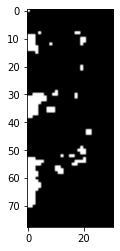

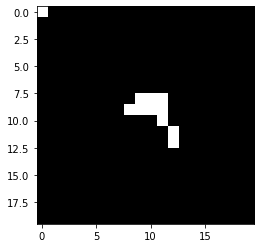

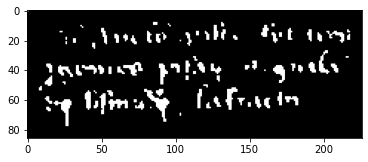

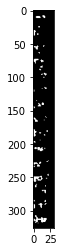

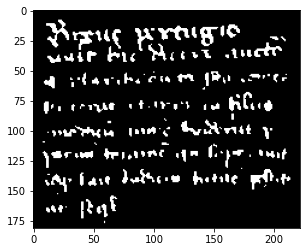

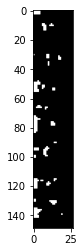

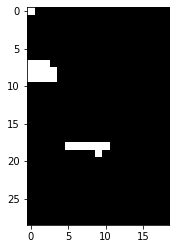

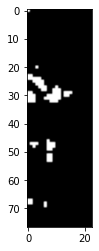

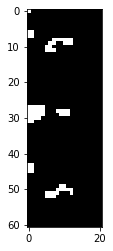

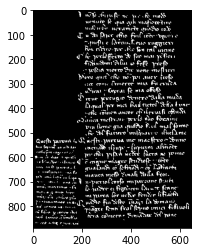

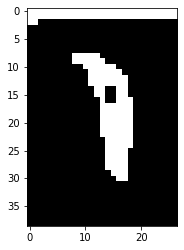

In [29]:
images = []
for i in range(11):
    image1 = cv2.imread("cropped_image" + str(i) + ".png")
#plt.imshow(image1)
    grayImage= cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
#plt.imshow(grayImage)
    GaussianFilter= cv2.GaussianBlur(grayImage, (5,5), 0)
    _, binarizedImage = cv2.threshold(GaussianFilter, 127, 255, cv2.THRESH_BINARY)
    plt.figure()
    plt.imshow(binarizedImage, cmap='Greys_r')
    height, width= binarizedImage.shape

    for i in range(height):
        for j in range(width):
        # img[i, j] is the RGB pixel at position (i, j)
        # check if it's [0, 0, 0] and replace with [255, 255, 255] if so
            if binarizedImage[i, j] == 0:
                binarizedImage[i, j] =255
            else:
                binarizedImage[i, j] = 0
    images.append(binarizedImage)
    plt.imshow(binarizedImage, cmap='Greys_r')          

In [33]:
print(len(images))

11


In [34]:

img_row_sum = []
for i in range(11):
    img_row_sum.append(np.sum(images[i],axis=1).tolist())
    plt.figure(figsize=(5,5))
    plt.show()


<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [36]:
from scipy.signal import find_peaks
peaks_image = []
for i in range(11):
    x =img_row_sum[i]
    peaks, _ = find_peaks(x, distance=15)
    peaks_image.append(peaks)


None
None
None
None
None
None
None
None
None
None
None


In [37]:
print(peaks_image)

[array([11, 31, 54], dtype=int64), array([9], dtype=int64), array([16, 38, 61], dtype=int64), array([ 10,  35,  54,  74,  95, 116, 140, 162, 183, 206, 228, 249, 269,
       290, 313], dtype=int64), array([ 18,  37,  58,  79, 100, 119, 140, 163], dtype=int64), array([ 10,  32,  53,  77,  94, 130], dtype=int64), array([18], dtype=int64), array([30, 47, 68], dtype=int64), array([ 8, 28, 50], dtype=int64), array([ 22,  49,  74, 104, 132, 161, 188, 217, 243, 273, 299, 327, 342,
       357, 373, 392, 416, 444, 473, 500, 535, 560, 587, 604, 620, 643,
       675, 700, 727, 755, 783, 810, 838, 870], dtype=int64), array([12], dtype=int64)]


(78, 31)
(20, 20)
(86, 226)
(326, 31)
(181, 222)
(149, 27)
(29, 19)
(77, 23)
(61, 21)
(890, 647)
(39, 27)


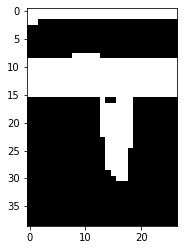

In [43]:
for k in range(11):
    newImage = images[k].copy()
    height, width= newImage.shape
    print(newImage.shape)
    for i in range(height):
        if(i in peaks_image[k]):
            for j in range(width):
                newImage[i,j] = 255
                newImage[i-1,j] = 255
                newImage[i+1,j] = 255
                newImage[i-2,j] = 255
                newImage[i+2,j] = 255
                newImage[i-3,j] = 255
                newImage[i+3,j] = 255
    plt.imshow(newImage, cmap='Greys_r')
    cv2.imwrite('linesdetected/cropped_image' + str(k) +'.png', newImage)
        

In [67]:
print(image_orig.shape[:-1])
print(img)
print(images[i])

(1344, 960)
<PIL.Image.Image image mode=L size=1344x960 at 0x26D8E1BAAF0>
[[255   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]



0 1068 31 78


TypeError: color must be int or tuple

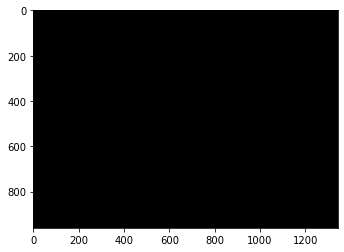

In [72]:
i = 0
img = Image.new('RGB', image_orig.shape[:-1])
plt.imshow(img, cmap='Greys_r')
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    print()
    print(x,y,w,h)
    img.paste(images[i], (x,y,w,h))
    i= i+1
img.save("pasted.grid.png")

In [ ]:
image = cv2.imread('cropped_image4.png')

In [ ]:

cv2.imshow("cropped", crop_img)
cv2.waitKey(0)
crop_img= cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)

In [ ]:
import cv2
import numpy as np

# read image
img = cv2.imread("cropped_image4.png")
img = img[65:75, :].copy()

# convert img to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# invert polarity
gray = 255 - gray

# do adaptive threshold on gray image
thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)[1]

# Get contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
i = 1
for c in cnts:
    # create white image
    result = np.full_like(img, (255,255,255))
    # get bounding box
    x,y,w,h = cv2.boundingRect(c)
    # crop region of img using bounding box
    region = img[y:y+h, x:x+w]
    # save region to new image
    cv2.imwrite("black_region_{0}.png".format(i), region)
    i = i + 1


# display it
#cv2.imshow("IMAGE", img)
#cv2.imshow("GRAY", gray)
cv2.imshow("THRESHOLD", thresh)
cv2.waitKey(0)

In [ ]:
img=thresh
ret,gray = cv2.threshold(img,127,255,0)
gray2 = gray.copy()
mask = np.zeros(gray.shape,np.uint8)

In [ ]:
contours, hier = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    if 200<cv2.contourArea(cnt)<5000:
        cv2.drawContours(img,[cnt],0,(0,255,0),2)
        cv2.drawContours(mask,[cnt],0,255,-1)

In [ ]:
cv2.imshow('IMG',gray2)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
GaussianFilter= cv2.GaussianBlur(crop_img, (5,5), 0)
_, binarizedImage = cv2.threshold(GaussianFilter, 127, 255, cv2.THRESH_BINARY)

In [ ]:
height, width = binarizedImage.shape
for i in range(height-1):
    for j in range(width-1):
        # img[i, j] is the RGB pixel at position (i, j)
        # check if it's [0, 0, 0] and replace with [255, 255, 255] if so
        if crop_img[i, j] == 0:
            crop_img[i, j] =255
        else:
            crop_img[i, j] = 0
plt.imshow(crop_img, cmap='Greys_r')   

In [ ]:
import matplotlib.pyplot as plt

from skimage.morphology import convex_hull_image
from skimage import data, img_as_float
from skimage.util import invert

# The original image is inverted as the object must be white.
image = invert(crop_img)

#chull = convex_hull_image(image)

contours, hier = cv2.findContours(image,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    if 200<cv2.contourArea(cnt)<5000:
        cv2.drawContours(img,[cnt],0,(0,255,0),2)
        cv2.drawContours(mask,[cnt],0,255,-1)

In [ ]:
import cv2


image= crop_img
original_image= image


edges= cv2.Canny(original_image, 50,200)


contours, hierarchy= cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


for cnt in contours:
    hull= cv2.convexHull(cnt)
    cv2.drawContours(image, [hull],0,(0,255,0),2)
    cv2.imshow('Convex Hull', image)


In [ ]:
from scipy.signal import argrelextrema
data = np.array(img_row_sum)

maximums = argrelextrema(data, np.greater, order =2)

print(maximums)


In [ ]:
height, width = binarizedImage.shape
print('width : ', width)
print('height : ', height)
horizontal_projection = np.sum(binarizedImage, axis=1);
print(horizontal_projection)

In [ ]:
horizontal_projection = np.sum(image1, axis=1)
print(horizontal_projection)
print(image1.shape)
blankImage = np.zeros((height, width, 3), np.uint8)
plt.figure()
plt.imshow(blankImage, cmap='Greys_r')
for row in range(height):
    cv2.line(blankImage, (0,row), (int(horizontal_projection[row]*width/height),row), (255,255,255), 1)

In [ ]:
plt.hist(image1.ravel(), 256, [0,256])
plt.show()

In [ ]:
img_row_sum = np.sum(image1,axis=1).tolist()

plt.plot(img_row_sum)
plt.show()

In [ ]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import time

THRESHOLD = 200
TABLE = [1]*THRESHOLD + [0]*(256-THRESHOLD)

def line_split(image, table=TABLE, split_threshold=4):

    if not isinstance(image, Image.Image):
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        else:
            raise TypeError

    image_ = image.convert('L')
    bn = image_.point(table, '1')

    bn_mat = np.array(bn)
    h, pic_len = bn_mat.shape


    bn_mat_diff = np.diff(bn_mat)
    project = np.sum(bn_mat_diff, 1) 
    pos = np.where(project <= split_threshold)[0]  
    project[pos] = 0
    transformed=np.fft.fft(project)
    itransformed_real = np.real(np.fft.ifft(transformed))
    signal = np.around(itransformed_real)
    pos = np.where(signal <= 0)[0]

    diff = np.diff(pos)

    coordinate = list(zip(pos[:-1], pos[1:]))
    info = list(zip(diff, coordinate))
    info = list(filter(lambda x: x[0] > 10, info))
    line_res = []
    for pos_info in info:
        width = pos_info[0]
        x1, y1, x2, y2 = 0, pos_info[1][0]-int(0.1*width), pic_len, pos_info[1][1]+int(0.1*width)
        sub = image.crop((x1, y1, x2, y2))
        line_res.append([np.array(sub), (x1, y1, x2, y2)])
    return line_res



img = cv2.imread('cropped_image4.png')
t1 = time.time()
line_imgs = line_split(img)
t2 = time.time()
print("Cost time: {}".format(t2-t1))
tmp = 0
for line_img in line_imgs:
    cv2.imwrite('./debug/'+str(tmp)+'.jpg',line_img[0])
    tmp += 1
    start = line_img[1][0],line_img[1][3]
    end = line_img[1][2],line_img[1][3]
    cv2.line(img,start,end,(0,0,255),1)
cv2.imwrite('line_split_result.jpg',img)

In [ ]:
plt.imshow(img)

In [ ]:
dst = cv2.GaussianBlur(img,(9,9),cv2.BORDER_DEFAULT)
 
# display input and output image
cv2.imshow("Gaussian Smoothing",np.hstack((img, dst)))
cv2.waitKey(0) # waits until a key is pressed

In [ ]:
plt.hist(img)